In [1]:
import numpy

In [2]:
import cobra, cobra.io, cobra.sampling
import scipy, scipy.signal

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'xtick.labelsize':20, 
                            'ytick.labelsize':20, 
                            'axes.labelsize':20, 
                            'figure.figsize':(12 * 0.6, 9 * 0.6)})

# user-defined variables

In [4]:
low_number_of_points = 100
high_number_of_points = 10000
threads = 4

# read the model

In [5]:
%%time
model = cobra.io.read_sbml_model('model_out_Static_90.sbml.xml')
solution = model.optimize()

No objective in listOfObjectives
No objective coefficients in model. Unclear what should be optimized


CPU times: user 7.51 s, sys: 292 ms, total: 7.8 s
Wall time: 7.82 s


In [6]:
print(type(model.solver))

print(solution.fluxes['biomass_maintenance'])

model.reactions.biomass_maintenance

<class 'optlang.cplex_interface.Model'>
143.582775499576


Reaction identifier,biomass_maintenance
Name,Biomass maintenance reaction without replication precursors
Memory address,0x2b2e1b110
Stoichiometry,0.50563 ala_L[c] + 0.35926 arg_L[c] + 0.27942 asn_L[c] + 0.35261 asp_L[c] + 20.7045 atp[c] + 0.020401 chsterol[c] + 0.011658 clpn_hs[c] + 0.039036 ctp[c] + 0.046571 cys_L[c] + 0.27519 g6p[c] +... 0.50563 L-Alanine + 0.35926 L-Arginine + 0.27942 L-Asparagine + 0.35261 L-Aspartate + 20.7045 Adenosine Triphosphate + 0.020401 Cholesterol + 0.011658 Cardiolipin + 0.039036...
GPR,
Lower bound,143.582775499576
Upper bound,1000.0


Why 143 and not 159?

# random sampling

## optgp method

In [7]:
%%time
cloud = cobra.sampling.sample(model, low_number_of_points)
cloud.head()

CPU times: user 6min 43s, sys: 5.04 s, total: 6min 48s
Wall time: 4min 2s


,10FTHF7GLUtl,10FTHF7GLUtm,10FTHFtl,13DAMPPOX,2AMADPTm,2HBO,2HBt2,2OXOADOXm,2OXOADPTm,34DHOXPEGOX,...,sink_asp_L[c],sink_glu_L[c],sink_pro_L[c],sink_ser_L[c],sink_gly[c],sink_4abut[l],DM_4glu56dihdind[c],DM_4abut[c],DM_btn[m],DCMPtm
0,0.002105,0.002032,-0.002105,0.001995,0.000711,0.000514,-896.444574,0.002198,0.001802,-0.001840,...,855.732135,-999.962451,-994.500835,11.318552,-994.152278,-0.015525,0.018720,0.029587,0.022727,-920.145740
1,0.002155,0.002082,-0.002155,0.001946,0.000681,0.000663,-896.478453,0.002362,0.001995,-0.001840,...,855.739532,-999.966436,-994.503055,11.326084,-994.147058,-0.016346,0.017302,0.030359,0.024637,-920.142995
2,0.001430,0.001357,-0.001430,0.001946,0.000913,-0.000175,-896.470944,0.002245,0.001645,-0.001681,...,855.756630,-999.971554,-994.512114,11.316535,-994.154612,-0.015678,0.015834,0.023386,0.020846,-920.136187
3,0.423215,0.371722,-0.423215,1.027245,0.533079,0.684935,339.497118,1.549836,1.238229,-1.047247,...,927.360238,-990.197149,-942.138970,612.864261,-540.811529,-9.733805,1.931266,17.332611,8.844045,-964.975432
4,0.424457,0.373004,-0.424457,1.044354,0.342614,-1.268736,349.937448,1.558458,1.437143,-1.097246,...,928.529060,-990.586541,-941.533761,604.950738,-534.761636,-8.376665,1.961282,18.061019,8.668252,-963.323037


In [8]:
%%time
optgp_cloud_low = cobra.sampling.sample(model, low_number_of_points, processes=threads)

CPU times: user 6min 45s, sys: 7.42 s, total: 6min 52s
Wall time: 4min 8s


In [9]:
%%time
cloud = cobra.sampling.sample(model, high_number_of_points)

CPU times: user 10min 24s, sys: 26 s, total: 10min 50s
Wall time: 8min 1s


In [10]:
%%time
optgp_cloud_high = cobra.sampling.sample(model, high_number_of_points, processes=threads)

CPU times: user 6min 45s, sys: 8.21 s, total: 6min 53s
Wall time: 5min 25s


Conclusions:
- Multiple threading has no substantial effect, the parallel part is minimal. Efficiency will be maximal in low parallel environments.
- Asking for 100 or 10,000 has not substantial effect on computational time.

## achr method
It does not accept multiple threads.

In [11]:
%%time
achr_cloud_low = cobra.sampling.sample(model, low_number_of_points, method="achr")

CPU times: user 6min 46s, sys: 6.76 s, total: 6min 52s
Wall time: 4min 7s


In [12]:
%%time
achr_cloud_high = cobra.sampling.sample(model, high_number_of_points, method="achr")

CPU times: user 10min 29s, sys: 7.18 s, total: 10min 36s
Wall time: 7min 44s


# storage

In [13]:
clouds = [optgp_cloud_low, optgp_cloud_high, achr_cloud_low, achr_cloud_high]
cloud_names = ['optgp_cloud_low', 'optgp_cloud_high', 'achr_cloud_low', 'achr_cloud_high']

for i in range(len(clouds)):
    clouds[i].to_csv(cloud_names[i], sep='\t')    

# visualization

In [14]:
cloud_colors = ['skyblue', 'gold', 'tab:green', 'tab:red']

143.5827830553775 143.614484940973
143.58277748627745 144.00285087138911
143.58277702961723 143.59059079990794
143.58277566958725 145.87080239095604


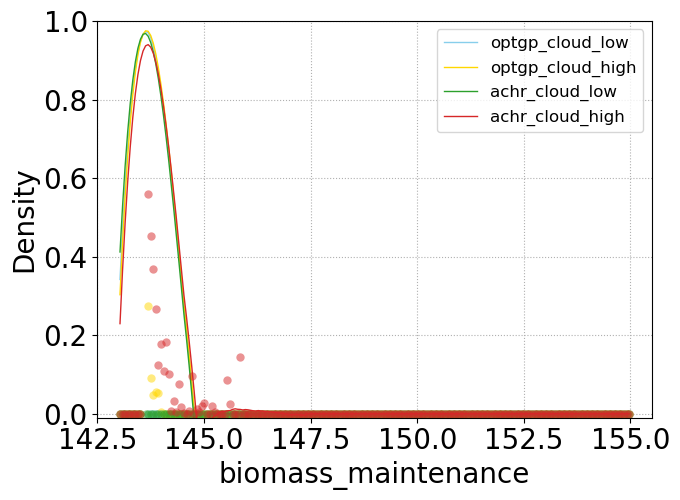

In [15]:
for i in range(len(clouds)):
    cloud = clouds[i]
    the_color = cloud_colors[i]
    bm = cloud['biomass_maintenance']
    print(numpy.min(bm), numpy.max(bm))
    hist, bin_edges = numpy.histogram(bm, bins=200, range=(143, 155), density=True)
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]

    # plot points
    matplotlib.pyplot.plot(x, hist, 'o', alpha=1/2, color=the_color, mec='none')

    # fit and plot line
    yhat = scipy.signal.savgol_filter(hist, 51, 3)
    matplotlib.pyplot.plot(x, yhat, '-', lw=1, color=the_color, label=cloud_names[i])

matplotlib.pyplot.xlabel('biomass_maintenance')
matplotlib.pyplot.ylabel('Density')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.legend(fontsize=12)
matplotlib.pyplot.ylim(-0.01, 1)
matplotlib.pyplot.xlim(142.5, 155.5)

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# adding constrains

In [16]:
print(solution.fluxes['biomass_maintenance'])
bottom = solution.fluxes['biomass_maintenance']*0.90
print(bottom)

143.582775499576
129.2244979496184


In [17]:
model.reactions.biomass_maintenance

Reaction identifier,biomass_maintenance
Name,Biomass maintenance reaction without replication precursors
Memory address,0x2b2e1b110
Stoichiometry,0.50563 ala_L[c] + 0.35926 arg_L[c] + 0.27942 asn_L[c] + 0.35261 asp_L[c] + 20.7045 atp[c] + 0.020401 chsterol[c] + 0.011658 clpn_hs[c] + 0.039036 ctp[c] + 0.046571 cys_L[c] + 0.27519 g6p[c] +... 0.50563 L-Alanine + 0.35926 L-Arginine + 0.27942 L-Asparagine + 0.35261 L-Aspartate + 20.7045 Adenosine Triphosphate + 0.020401 Cholesterol + 0.011658 Cardiolipin + 0.039036...
GPR,
Lower bound,143.582775499576
Upper bound,1000.0


In [18]:
model.reactions.biomass_maintenance.lower_bound = bottom

In [19]:
model.reactions.biomass_maintenance

Reaction identifier,biomass_maintenance
Name,Biomass maintenance reaction without replication precursors
Memory address,0x2b2e1b110
Stoichiometry,0.50563 ala_L[c] + 0.35926 arg_L[c] + 0.27942 asn_L[c] + 0.35261 asp_L[c] + 20.7045 atp[c] + 0.020401 chsterol[c] + 0.011658 clpn_hs[c] + 0.039036 ctp[c] + 0.046571 cys_L[c] + 0.27519 g6p[c] +... 0.50563 L-Alanine + 0.35926 L-Arginine + 0.27942 L-Asparagine + 0.35261 L-Aspartate + 20.7045 Adenosine Triphosphate + 0.020401 Cholesterol + 0.011658 Cardiolipin + 0.039036...
GPR,
Lower bound,129.2244979496184
Upper bound,1000.0


# re-sampling

In [20]:
%%time
optgp_cloud_high_constrained = cobra.sampling.sample(model, high_number_of_points, processes=threads)

CPU times: user 6min 58s, sys: 8.23 s, total: 7min 6s
Wall time: 5min 39s


In [21]:
%%time
achr_cloud_high_constrained = cobra.sampling.sample(model, high_number_of_points, method="achr")

CPU times: user 10min 51s, sys: 6.43 s, total: 10min 57s
Wall time: 7min 58s


# visualization after resampling

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


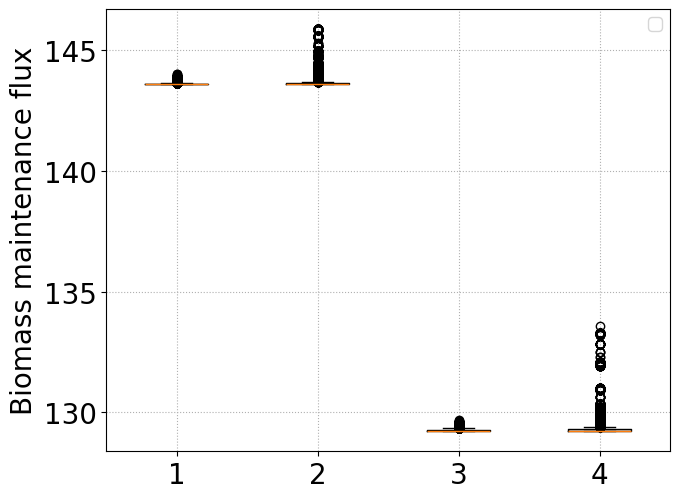

In [22]:
a = optgp_cloud_high['biomass_maintenance']
b = achr_cloud_high['biomass_maintenance']
c = optgp_cloud_high_constrained['biomass_maintenance']
d = achr_cloud_high_constrained['biomass_maintenance']
data = [a, b, c, d]

matplotlib.pyplot.boxplot(data, notch=True, patch_artist=True)

matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.legend(fontsize=12)
matplotlib.pyplot.ylabel('Biomass maintenance flux')

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()